# Kaggle Competition: Histopathologic Cancer Detection
   -https://www.kaggle.com/c/histopathologic-cancer-detection
   
"In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates)."

[1] B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962

Public Kernals Referenced - https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing

## Import necessary Keras libraries for both image pre-processing and convnets

In [1]:
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


## Import Necessary Scikit Learn libraries for testing and validation

In [2]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Import Necessary libraries for house cleaning and directory structure

In [44]:
import numpy as np
import pandas as pd
import shutil
import os
from glob import glob
import itertools

## Define the local directores for all image files for image classification. Restructure local directories to only include files by the corrosponding label.

In [4]:
#Define the current directories for all files. 
#Generate a dataframe from the train_labels.csv file.
Primary_dir = ('D:/Kaggle/Cancer Detection/histopathologic-cancer-detection/')
train = ('D:/Kaggle/Cancer Detection/histopathologic-cancer-detection/train/')
test = ('D:/Kaggle/Cancer Detection/histopathologic-cancer-detection/test/')
labels = pd.read_csv('D:/Kaggle/Cancer Detection/histopathologic-cancer-detection/train_labels.csv')

In [5]:
#Preview the total number of files provided and the train_labels.csv
print('Train Files =',len(os.listdir(train)), 'Validation Files =',len(os.listdir(test)))

Train Files = 220025 Validation Files = 57458


In [6]:
#Build a single dataframe that includes each of the images unique id, file path, and corrosponding label (1,0).
df = pd.DataFrame({'path': glob(os.path.join(train,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('\\')[1].split(".")[0])
df_data = df.merge(labels, on = 'id')
df_data.head()

,path,id,label
0,D:/Kaggle/Cancer Detection/histopathologic-can...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,D:/Kaggle/Cancer Detection/histopathologic-can...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,D:/Kaggle/Cancer Detection/histopathologic-can...,00004aab08381d25d315384d646f5ce413ea24b1,0
3,D:/Kaggle/Cancer Detection/histopathologic-can...,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
4,D:/Kaggle/Cancer Detection/histopathologic-can...,0000da768d06b879e5754c43e2298ce48726f722,1


In [7]:
#preview the count of images by their corrosponding label.
df_data.groupby('label').id.nunique()

label
0    130908
1     89117
Name: id, dtype: int64

## We will need a balanced random sample of all images by classification (50/50). We want to prevent any bias in our convnet due to overfitting to our training data.

In [8]:
SAMPLE_SIZE = 80000
# take a random sample of class 0
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# take a random sample of class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)
#Shuffle and concatenate both df_0 and df_1 into one dataframe.
df_data = shuffle(pd.concat([df_0, df_1], axis=0).reset_index(drop=True))
#Count distinct ids by corrosponding label (50/50 split)
df_data.groupby('label').id.nunique()

label
0    80000
1    80000
Name: id, dtype: int64

## Use the train_test_split function to break our data into both a training set and validation set (90/10) split due to the vast amount of images available)

In [9]:
#Breakout df_data into two groups via train test split. Validation group will consist of 10% of our total images. 
y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

## Generate new directores to process data into our model

In [15]:
os.mkdir('D:/Kaggle/Cancer Detection/histopathologic-cancer-detection/train_dir')
os.mkdir('D:/Kaggle/Cancer Detection/histopathologic-cancer-detection/val_dir')
os.mkdir('D:/Kaggle/Cancer Detection/histopathologic-cancer-detection/test_dir')

In [16]:
os.mkdir('D:/Kaggle/Cancer Detection/histopathologic-cancer-detection/train_dir/a_no_tumor_tissue')
os.mkdir('D:/Kaggle/Cancer Detection/histopathologic-cancer-detection/train_dir/b_has_tumor_tissue')
os.mkdir('D:/Kaggle/Cancer Detection/histopathologic-cancer-detection/val_dir/a_no_tumor_tissue')
os.mkdir('D:/Kaggle/Cancer Detection/histopathologic-cancer-detection/val_dir/b_has_tumor_tissue')

## Transfer images to the correct folders based on labels. 
Referenced public kernal for guidance - https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing

In [22]:
train_list = list(df_train['id'])
val_list = list(df_val['id'])
df_data.set_index('id',inplace=True)

# Transfer the train images
for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('D:/Kaggle/Cancer Detection/histopathologic-cancer-detection/train/', fname)
    # destination path to image
    dst = os.path.join('D:/Kaggle/Cancer Detection/histopathologic-cancer-detection/train_dir/', label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    
# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('D:/Kaggle/Cancer Detection/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join('D:/Kaggle/Cancer Detection/histopathologic-cancer-detection/val_dir/', label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [10]:
#Validate images in our local directories 
print(len(os.listdir('C:/Kaggle/train_dir/a_no_tumor_tissue')))
print(len(os.listdir('C:/Kaggle/train_dir/b_has_tumor_tissue')))
print(len(os.listdir('C:/Kaggle/val_dir/a_no_tumor_tissue')))
print(len(os.listdir('C:/Kaggle/val_dir/b_has_tumor_tissue')))

72000
72000
8000
8000


In [11]:
train_path = 'C:/Kaggle/train_dir/'
valid_path = 'C:/Kaggle/val_dir/'
test_path = 'C:\Kaggle/test_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

## Specify the standard image size (96 pixels) and image channels (3 R/G/B). Designate the class_mode variable as 'binary' as this is a binary (1/0) classification problem. Use flow_from_directory to generate a pipeline for our images.

In [12]:
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3

datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


## Convnet was modeled after VGGnet due to  increased depth. Could not complete all 16/19 layers due to resource constraints with GPU.
Example:http://cs231n.github.io/convolutional-networks/

VGGNet: http://www.robots.ox.ac.uk/~vgg/research/very_deep/

In [13]:
kernel_size = (3,3) #Height and Width of the convolution window. 
pool_size= (2,2) #Size of the max pooling windows
first_filters = 32 
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 42, 42, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 64)        0         
__________

## Utilizing the adam optimizor and the binary_crossentropy loss function. 
## Goal: Optimize accuracy and minimize loss
## During training our model will optimize on validation accuracy and save only the weights that generate the best results. Our learning rate will be reduced by a factor of .5 upon plateau. We will go through 20 iterations (epochs) to see the benefits of backpropogation.

In [14]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [15]:
filepath = "model.h1"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/20
14400/14400 [==============================] - 212s 15ms/step - loss: 0.4355 - acc: 0.7982 - val_loss: 0.4023 - val_acc: 0.8139

Epoch 00001: val_acc improved from -inf to 0.81387, saving model to model.h1
Epoch 2/20
14400/14400 [==============================] - 184s 13ms/step - loss: 0.3421 - acc: 0.8517 - val_loss: 0.3571 - val_acc: 0.8511

Epoch 00002: val_acc improved from 0.81387 to 0.85106, saving model to model.h1
Epoch 3/20
14400/14400 [==============================] - 184s 13ms/step - loss: 0.2931 - acc: 0.8762 - val_loss: 0.2802 - val_acc: 0.8784

Epoch 00003: val_acc improved from 0.85106 to 0.87844, saving model to model.h1
Epoch 4/20
14400/14400 [==============================] - 186s 13ms/step - loss: 0.2668 - acc: 0.8894 - val_loss: 0.2587 - val_acc: 0.8926

Epoch 00004: val_acc improved from 0.87844 to 0.89262, saving model to model.h1
Epoch 5/20
14400/14400 [==============================] - 185s 13ms/step - loss: 0.2472 - acc: 0.8994 - val_loss: 0.2955 - 

In [16]:
#The weights with the best validation accuracy will be used for our predictions and validation.

model.load_weights('model.h1')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.13498015315371129
val_acc: 0.9516875


<function matplotlib.pyplot.show(*args, **kw)>

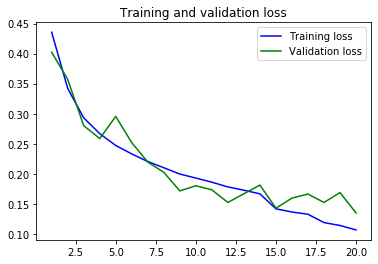

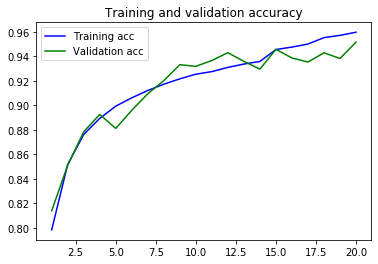

<Figure size 432x288 with 0 Axes>

In [18]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, '-b', label='Training loss')
plt.plot(epochs, val_loss, '-g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, '-b', label='Training acc')
plt.plot(epochs, val_acc, '-g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show

In [19]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

16000/16000 [==============================] - 22s 1ms/step


In [20]:
y_pred = pd.DataFrame(predictions, columns =['has_tumor_issue'])

In [21]:
y_true = pd.DataFrame(test_gen.classes)

In [22]:
roc_auc_score(y_true, y_pred)

0.9890202656250001

In [23]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

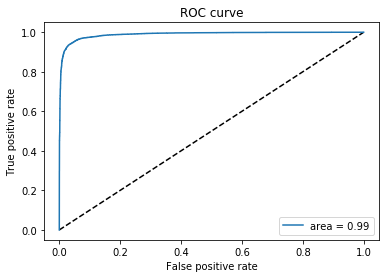

In [24]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.2f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [25]:
test_labels = test_gen.classes

In [40]:
cm = confusion_matrix(y_true, np.round(predictions,0))

In [41]:
val_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

In [42]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[7565  435]
 [ 338 7662]]


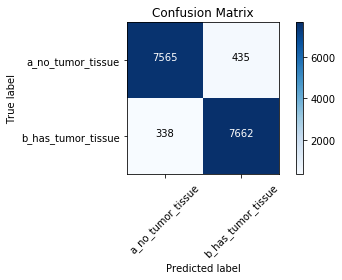

In [45]:
cm_plot_labels = ['a_no_tumor_tissue', 'b_has_tumor_tissue']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [46]:
#Round predictions to 1/0
y_pred_1 = np.round(predictions,0)
report = classification_report(y_true, y_pred_1, target_names=cm_plot_labels)
print(report)

                    precision    recall  f1-score   support

 a_no_tumor_tissue       0.96      0.95      0.95      8000
b_has_tumor_tissue       0.95      0.96      0.95      8000

         micro avg       0.95      0.95      0.95     16000
         macro avg       0.95      0.95      0.95     16000
      weighted avg       0.95      0.95      0.95     16000

